<a href="https://colab.research.google.com/github/Gaukhar-ai/for_my_Thinkful_work/blob/master/Clustering_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.mixture import GaussianMixture
#run kmeans and gaussian and interpret, keep how many clusters i need and change
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy.special import entr
import plotly.express as px
from sklearn import preprocessing

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Gaukhar-ai/for_my_Thinkful_work/master/capstone/Stock%20Market_1B_predictions/stock_market_data.csv')
df.head()

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,assetsc,liabilitiesc,price,calendardate,datekey,sharesbas,equity,receivables,investmentsc,cashneq,assetsavg,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
0,ZYME,8269000.0,3.091,9007000.0,636578000.0,-3.765,-37487000.0,48686718.0,0.170,-35880000.0,504608000.0,72905000.0,35.47,3/31/2020,3/31/2020,45518869.0,522419000.0,8653000.0,298179000.0,189485000.0,454841750.0,-162932000.0,-2.154,3.091,-0.358217,-4.339097835,-0.823549,0.181661,-16.467038,6.807722,0.014149
1,ZYME,1877000.0,7.288,6881000.0,368205000.0,-38.489,-36354000.0,43658717.0,0.043,-73752000.0,311830000.0,82552000.0,45.46,12/31/2019,12/31/2019,39387339.0,245681000.0,2185000.0,170453000.0,128451000.0,355267000.0,-145437000.0,-2.319,7.288,-0.409374,-39.29248801,-0.922987,0.047655,-19.603277,3.647265,0.018688
2,ZYME,7860000.0,3.146,6755000.0,400037000.0,-3.877,-10880000.0,43445379.0,0.181,-33564000.0,345311000.0,50689000.0,24.80,9/30/2019,9/30/2019,39259938.0,309525000.0,3420000.0,84259000.0,250844000.0,324335000.0,-63920000.0,0.004,3.146,-0.197080,-4.270229008,-0.277127,0.200204,6200.000000,6.678431,0.016886
3,ZYME,7882000.0,2.112,7829000.0,414547000.0,-3.689,-13317000.0,32837975.0,0.240,-29432000.0,366425000.0,40392000.0,22.00,6/30/2019,6/30/2019,32061624.0,334017000.0,2796000.0,72130000.0,283520000.0,272935750.0,-52196000.0,0.028,2.112,-0.191239,-3.734077645,-0.415356,0.245839,785.714286,8.874183,0.018886
4,ZYME,11925000.0,3.048,8065000.0,238279000.0,-1.144,-21302000.0,32020437.0,0.372,-14553000.0,190330000.0,28156000.0,16.18,3/31/2019,3/31/2019,32025299.0,170007000.0,1035000.0,137134000.0,43174000.0,222047750.0,-28993000.0,0.616,3.048,-0.130571,-1.220377358,-0.665162,0.372362,26.266234,6.440652,0.033847


In [3]:
df.shape

(40277, 31)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40277 entries, 0 to 40276
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ticker                   40277 non-null  object 
 1   revenue                  39949 non-null  float64
 2   pb                       38433 non-null  float64
 3   debt                     39416 non-null  float64
 4   assets                   39416 non-null  float64
 5   netmargin                38980 non-null  float64
 6   ncfo                     39683 non-null  float64
 7   shareswa                 40072 non-null  float64
 8   sps                      39800 non-null  float64
 9   opinc                    39949 non-null  float64
 10  assetsc                  30302 non-null  float64
 11  liabilitiesc             30265 non-null  float64
 12  price                    38513 non-null  float64
 13  calendardate             40277 non-null  object 
 14  datekey               

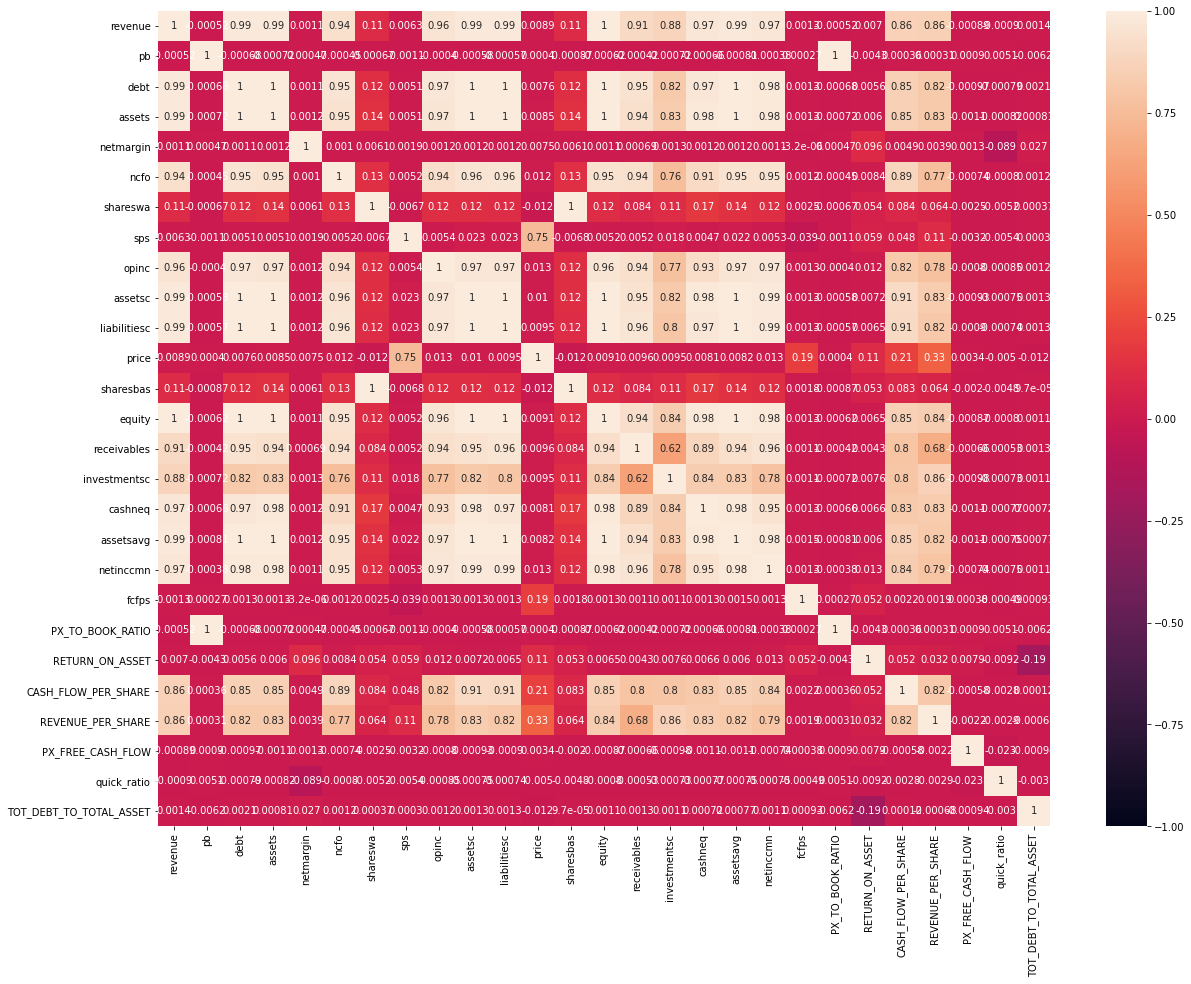

In [5]:
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [6]:
df['datekey'].nunique()
#i see that i have two types of dates above: datekey and calendardate. Checking how many rows of datekey I have

584

In [7]:
df['calendardate'].nunique() #let's see how many rows in calendardate

22

In [8]:
(df['datekey'] == df['calendardate']).mean() # 83% they match, I see that they're highly correlated, so I can drop one of them.


0.8301015467884897

In [9]:
df['calendardate'].unique() 
#deciding which quarter to pick. Futher I'll investigate clusters based on the chosen dates.

array(['3/31/2020', '12/31/2019', '9/30/2019', '6/30/2019', '3/31/2019',
       '12/31/2018', '9/30/2018', '6/30/2018', '3/31/2018', '12/31/2017',
       '9/30/2017', '6/30/2017', '3/31/2017', '12/31/2016', '12/31/2015',
       '9/30/2016', '6/30/2016', '3/31/2016', '9/30/2015', '6/30/2015',
       '3/31/2015', '6/30/2020'], dtype=object)

In [10]:
df['calendardate'] = pd.to_datetime(df['calendardate'])

In [11]:
#picked the dates 
df = df[df['calendardate'].between('2019-10-01', '2020-01-01')]
df.head()

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,assetsc,liabilitiesc,price,calendardate,datekey,sharesbas,equity,receivables,investmentsc,cashneq,assetsavg,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
1,ZYME,1.877000e+06,7.288,6.881000e+06,3.682050e+08,-38.489,-36354000.0,43658717.0,0.043,-73752000.0,3.118300e+08,8.255200e+07,45.46,2019-12-31,12/31/2019,39387339.0,2.456810e+08,2.185000e+06,170453000.0,1.284510e+08,3.552670e+08,-1.454370e+08,-2.319,7.288,-0.409374,-39.29248801,-0.922987,0.047655,-19.603277,3.647265,0.018688
16,ZUO,7.039300e+07,10.140,7.858800e+07,4.022270e+08,-0.337,4009000.0,113180000.0,0.622,-24449000.0,2.667840e+08,1.656200e+08,14.75,2019-12-31,1/31/2020,113200000.0,1.646590e+08,6.887500e+07,117662000.0,5.427500e+07,3.426015e+08,-8.339400e+07,-0.225,10.140,-0.243414,-0.347321467,0.035415,0.621846,-65.555556,1.454003,0.195382
30,ZTS,1.674000e+09,23.279,6.611000e+09,1.154500e+10,0.229,582000000.0,476412000.0,3.514,493000000.0,4.748000e+09,1.806000e+09,132.35,2019-12-31,12/31/2019,476299250.0,2.708000e+09,1.086000e+09,0.0,1.934000e+09,1.117150e+10,1.500000e+09,2.792,23.279,0.134270,0.294504182,1.221921,3.514597,47.403295,1.672204,0.572629
51,ZS,1.012680e+08,22.487,3.444200e+07,6.764250e+08,-0.288,5431000.0,128408000.0,0.789,-30280000.0,5.231420e+08,3.036630e+08,56.09,2019-12-31,1/31/2020,127957453.0,3.191640e+08,9.478400e+07,308380000.0,7.653400e+07,6.135878e+08,-6.374200e+07,0.153,22.487,-0.103884,-0.299008571,0.042444,0.791419,366.601307,1.579705,0.050918
65,ZNGA,4.044630e+08,2.931,7.165100e+08,3.660614e+09,-0.009,94049000.0,947733000.0,0.427,4332000.0,1.575670e+09,7.919680e+08,6.12,2019-12-31,12/31/2019,945922482.0,1.975430e+09,1.400780e+08,938173000.0,4.533290e+08,3.268752e+09,4.192500e+07,0.873,2.931,0.012826,0.010710498,0.099426,0.427586,7.010309,1.933891,0.195735


In [12]:
#converting operating margin to a numerical data, apparently there're NAs, which is giving it as an object.

df['OPER_MARGIN'] = pd.to_numeric(df['OPER_MARGIN'],errors='coerce') #errors = 'coerse' - converts to NA

In [13]:
from scipy.stats.mstats import winsorize
import scipy.stats

In [15]:
#applying winsorization here. It is to transform the statistics by limiting extreme values in the statistical data
#to reduce the effect of possibly spurious outliers.

q_low = df['netmargin'].quantile(0.05)
q_hi = df['netmargin'].quantile(0.98)

df = df[(df['netmargin'] < q_hi) & (df['netmargin']>q_low)]

(array([ 37.,  59., 142., 554., 395., 171., 151.,  99.,  54.,  30.]),
 array([-0.22 , -0.147, -0.074, -0.001,  0.072,  0.145,  0.218,  0.291,
         0.364,  0.437,  0.51 ]),
 <a list of 10 Patch objects>)

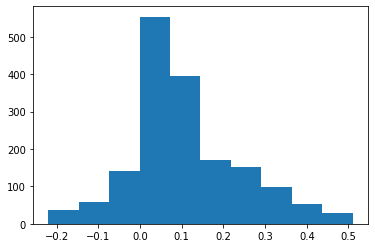

In [16]:
plt.hist(round(df['netmargin'], 2), bins = 10) 

In [17]:
#applying Z score, to understand if a data value is greater or smaller than mean and how far away it is from the mean
#to see how many std away a data point is from the mean.

from scipy import stats

stats.zscore(round(df['netmargin'], 2)) 

#applied zscore to a 'netmargin', because it kept giving 0.99 for all the rows after scaling, 
#which obviously is not correct, the rest of the data was normal.

array([ 0.93194144, -0.89716817, -0.21125207, ..., -0.51610367,
       -1.73551008,  0.24602533])

In [18]:
#I'm checking if the data has the stocks I'm interested in. 
#So I realized looking at the output that it doesn't have all the stocks in the market. Also that stocks in the dataset 
#are more stable ones, so called 'long term growth stocks' but no penny stocks found.

df[df['ticker'].isin(['AMD', 'BA', 'GE', 'HTZ', 'AAL', 'NCLH', 'JILL', 'INTEQ', 'GLIBA', 'MRVL', 'NLOK'])] 

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,assetsc,liabilitiesc,price,calendardate,datekey,sharesbas,equity,receivables,investmentsc,cashneq,assetsavg,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
15741,NCLH,1.480618e+09,1.907,6.801693e+09,1.668460e+10,0.082,3.418510e+08,2.128776e+08,6.955,1.993760e+08,7.301450e+08,3.584390e+09,58.41,2019-12-31,12/31/2019,2.127575e+08,6.515579e+09,7.510900e+07,0.000000e+00,2.528760e+08,1.608764e+10,9.302280e+08,0.863,1.907,0.057823,0.134657,1.606763,6.959180,67.682503,0.091504,0.407663
22792,HTZ,2.325000e+09,1.265,1.893700e+10,2.462700e+10,-0.051,6.670000e+08,1.170000e+08,19.872,8.900000e+07,NaN,NaN,15.75,2019-12-31,12/31/2019,1.421217e+08,1.769000e+09,1.840000e+09,NaN,1.360000e+09,2.513800e+10,-5.800000e+07,-13.034,1.265,-0.002307,0.038280,4.693162,16.359223,-1.208378,NaN,0.768953
25128,GE,1.573700e+10,3.442,9.088200e+10,2.660480e+11,0.034,6.739000e+09,8.733549e+09,1.802,2.186000e+09,NaN,NaN,11.16,2019-12-31,12/31/2019,8.733549e+09,2.831600e+10,2.704700e+10,NaN,3.639400e+10,2.890620e+11,-5.439000e+09,0.732,3.442,-0.018816,0.138908,0.771622,1.801902,15.245902,NaN,0.341600
36147,BA,1.791100e+10,-21.276,2.730200e+10,1.336250e+11,-0.056,-2.220000e+09,5.627912e+08,31.825,-2.599000e+09,1.022290e+11,9.731200e+10,325.76,2019-12-31,12/31/2019,5.627912e+08,-8.617000e+09,1.460700e+10,5.450000e+08,9.485000e+09,1.281730e+11,-6.360000e+08,-7.011,-21.276,-0.004962,-0.145106,-3.944624,31.825300,-46.464128,0.253175,0.204318
38187,AMD,2.127000e+09,18.191,6.850000e+08,6.028000e+09,0.080,4.420000e+08,1.139000e+09,1.867,3.480000e+08,4.597000e+09,2.359000e+09,46.18,2019-12-31,12/28/2019,1.113628e+09,2.827000e+09,1.859000e+09,3.700000e+07,1.466000e+09,5.328500e+09,3.410000e+08,0.253,18.191,0.063995,0.163611,0.396901,1.909974,182.529644,1.425180,0.113636
40217,AAL,1.131300e+10,-106.470,3.344400e+10,5.999500e+10,0.037,6.000000e+08,4.380580e+08,25.825,7.290000e+08,8.206000e+09,1.831100e+10,28.68,2019-12-31,12/31/2019,4.380580e+08,-1.180000e+08,1.750000e+09,3.546000e+09,4.380000e+08,6.098100e+10,1.686000e+09,-0.911,-106.470,0.027648,0.064439,1.369682,25.825349,-31.481888,0.313145,0.557446


In [19]:
df.isna().sum() 

#cheching for null values

ticker                       0
revenue                      0
pb                           2
debt                         0
assets                       0
netmargin                    0
ncfo                         8
shareswa                     0
sps                          0
opinc                        0
assetsc                    390
liabilitiesc               391
price                        2
calendardate                 0
datekey                      0
sharesbas                    0
equity                       0
receivables                  0
investmentsc               390
cashneq                      0
assetsavg                    3
netinccmn                    3
fcfps                        6
PX_TO_BOOK_RATIO             2
RETURN_ON_ASSET              3
OPER_MARGIN                  0
CASH_FLOW_PER_SHARE          8
REVENUE_PER_SHARE            0
PX_FREE_CASH_FLOW            8
quick_ratio                391
TOT_DEBT_TO_TOTAL_ASSET      0
dtype: int64

In [20]:
df = df.replace([np.inf, -np.inf], np.nan)
#replacing any irrelevant values to null values

In [21]:
df = df.dropna() #dropping null values

In [22]:
df.isna().sum() #check if dropped

ticker                     0
revenue                    0
pb                         0
debt                       0
assets                     0
netmargin                  0
ncfo                       0
shareswa                   0
sps                        0
opinc                      0
assetsc                    0
liabilitiesc               0
price                      0
calendardate               0
datekey                    0
sharesbas                  0
equity                     0
receivables                0
investmentsc               0
cashneq                    0
assetsavg                  0
netinccmn                  0
fcfps                      0
PX_TO_BOOK_RATIO           0
RETURN_ON_ASSET            0
OPER_MARGIN                0
CASH_FLOW_PER_SHARE        0
REVENUE_PER_SHARE          0
PX_FREE_CASH_FLOW          0
quick_ratio                0
TOT_DEBT_TO_TOTAL_ASSET    0
dtype: int64

In [23]:
df.info()

#check for infinity how many rows were dropped

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1290 entries, 30 to 40257
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ticker                   1290 non-null   object        
 1   revenue                  1290 non-null   float64       
 2   pb                       1290 non-null   float64       
 3   debt                     1290 non-null   float64       
 4   assets                   1290 non-null   float64       
 5   netmargin                1290 non-null   float64       
 6   ncfo                     1290 non-null   float64       
 7   shareswa                 1290 non-null   float64       
 8   sps                      1290 non-null   float64       
 9   opinc                    1290 non-null   float64       
 10  assetsc                  1290 non-null   float64       
 11  liabilitiesc             1290 non-null   float64       
 12  price                    1290 no

In [24]:
df = df[~df['ticker'].isin(['AUPH', 'NK', 'ZYME', 'ZGNX', 'LBRDA', 'CRON', 'TM', 'LNG', 'KMB', 'SBL', 'NSP', 'CL', 'CHWY',
                           'SHOP', 'DDOG', 'HL', 'SBH', 'CDLX', 'MMSI', 'LGND'])] 

#filtering rows, dont need these outlier stocks, which really disturb the whole picture of the
#clusters~ Thought because of them I was getting netmargin at 0.99.
#These stocks need more investigation as a point to invest in. Some of them undervalued with a potential 
#to growth, some are just overvalued. 

In [25]:
#copying the df to df_original, to use it when needed, to see the ticker

df_original = df.copy()

In [26]:
keep_cols = ['TOT_DEBT_TO_TOTAL_ASSET', 'PX_FREE_CASH_FLOW', 'REVENUE_PER_SHARE', 'CASH_FLOW_PER_SHARE',
            'RETURN_ON_ASSET', 'PX_TO_BOOK_RATIO', 'quick_ratio', 'equity', 'netmargin']
df=df[keep_cols]
df.head()

#cleaned the data, these are the features I'll use for clustering stocks. They were created separately
#as a ratio, so all the stocks will be able to compare with each other. It won't be like AAPL and HTZ

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,REVENUE_PER_SHARE,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,equity,netmargin
30,0.572629,47.403295,3.514597,1.221921,0.134270,23.279,1.672204,2.708000e+09,0.229
65,0.195735,7.010309,0.427586,0.099426,0.012826,2.931,1.933891,1.975430e+09,-0.009
86,0.050232,156.673511,0.681077,0.132249,0.019134,25.289,2.922532,8.339430e+08,0.076
159,0.388717,200.602094,2.049213,0.287149,-0.117291,18.769,1.277170,4.579840e+08,-0.157
180,0.292295,22.073972,22.106219,4.914554,0.116389,7.490,0.457977,1.839000e+09,0.142


In [27]:
df.corr()

#check the correlation between features, looks good!

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,REVENUE_PER_SHARE,CASH_FLOW_PER_SHARE,RETURN_ON_ASSET,PX_TO_BOOK_RATIO,quick_ratio,equity,netmargin
TOT_DEBT_TO_TOTAL_ASSET,1.000000,0.018421,-0.006830,0.007980,-0.010036,-0.095792,-0.259424,-0.005418,-0.029119
PX_FREE_CASH_FLOW,0.018421,1.000000,-0.014996,-0.021757,0.047983,0.020073,0.049832,-0.004952,0.024310
REVENUE_PER_SHARE,-0.006830,-0.014996,1.000000,0.839969,-0.000321,-0.007418,-0.049523,0.768635,-0.033766
CASH_FLOW_PER_SHARE,0.007980,-0.021757,0.839969,1.000000,0.087450,-0.001314,-0.068912,0.632968,0.073953
RETURN_ON_ASSET,-0.010036,0.047983,-0.000321,0.087450,1.000000,-0.009954,0.009474,-0.003827,0.604645
PX_TO_BOOK_RATIO,-0.095792,0.020073,-0.007418,-0.001314,-0.009954,1.000000,0.019199,-0.004213,-0.009670
quick_ratio,-0.259424,0.049832,-0.049523,-0.068912,0.009474,0.019199,1.000000,-0.014019,0.137179
equity,-0.005418,-0.004952,0.768635,0.632968,-0.003827,-0.004213,-0.014019,1.000000,-0.001719
netmargin,-0.029119,0.024310,-0.033766,0.073953,0.604645,-0.009670,0.137179,-0.001719,1.000000


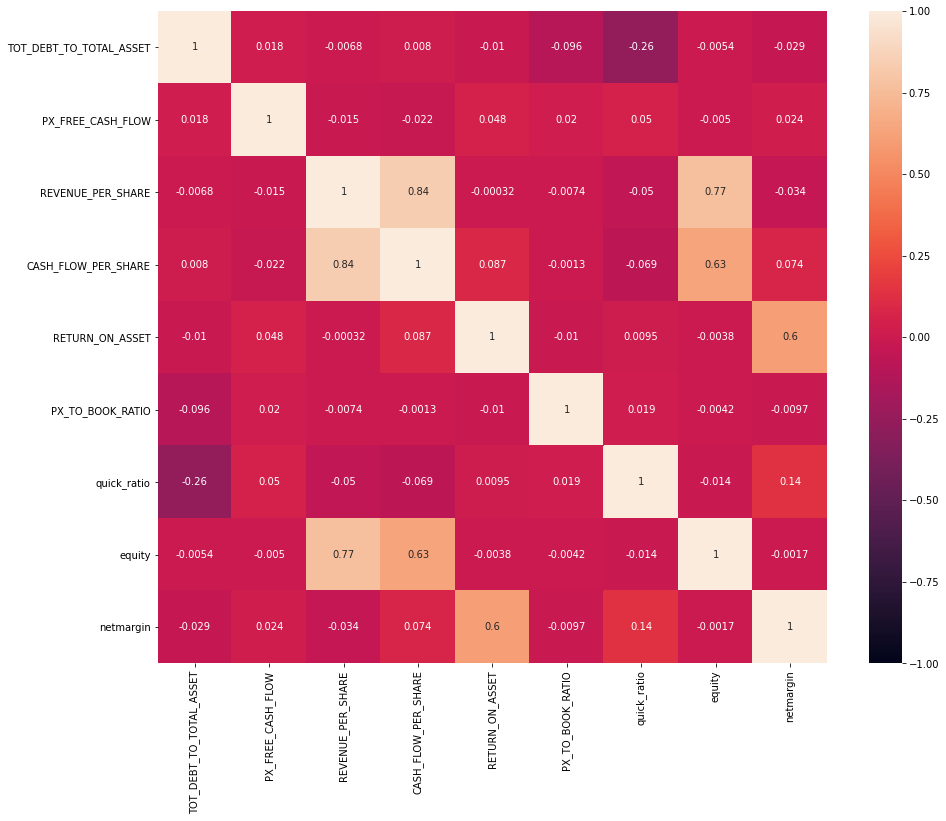

In [28]:
#let's use the visuals - the heatmap to see the correlation
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [29]:
#still see some leftover correlations, let's drop them too

drop_cols = ['equity', 'REVENUE_PER_SHARE', 'RETURN_ON_ASSET']
df.drop(drop_cols, axis = 1, inplace=True)
df.head()

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,PX_TO_BOOK_RATIO,quick_ratio,netmargin
30,0.572629,47.403295,1.221921,23.279,1.672204,0.229
65,0.195735,7.010309,0.099426,2.931,1.933891,-0.009
86,0.050232,156.673511,0.132249,25.289,2.922532,0.076
159,0.388717,200.602094,0.287149,18.769,1.277170,-0.157
180,0.292295,22.073972,4.914554,7.490,0.457977,0.142


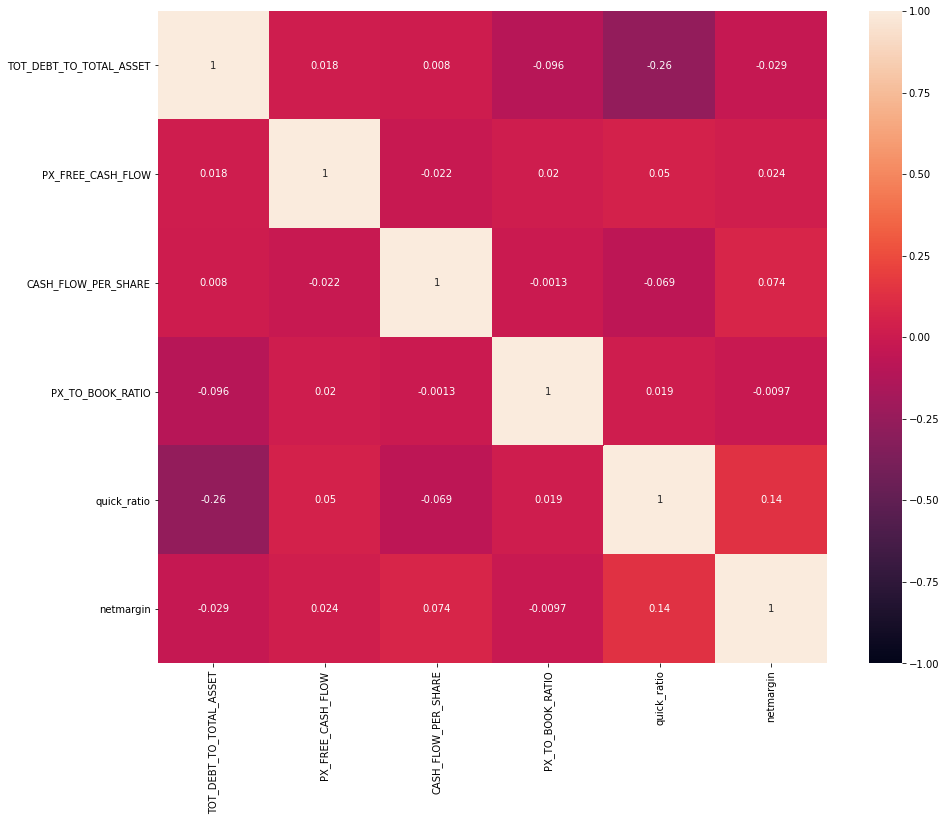

In [30]:
#now the data is clean

plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

In [ ]:
#Features definitions

TOT_DEBT_TO_TOTAL_ASSET = The debt to total assets ratio is an indicator of a company's financial leverage. It tells you the percentage of a company's total assets that were financed by creditors. ... Debt is the total amount of all liabilities (current liabilities and long-term liabilities).

PX_TO_BOOK_RATIO = is calculated by dividing a company's stock price by its book value per share. Low P/B ratios can be indicative of undervalued stocks, and can be useful when conducting a thorough analysis of a stock.

RETURN_ON_ASSET = ROA, Return on equity measures a corporation's profitability by calculating the amount of [NetIncCmn] returned as a percentage of [EquityAvg].

OPER_MARGIN = Operating margin is a profitability ratio that shows how much profit a company makes from its core operations in relation to the total revenues it brings in.

CASH_FLOW_PER_SHARE = Free Cash Flow per Share is a valuation metric calculated by dividing [FCF] by [SharesWA] and [ShareFactor].

PX_FREE_CASH_FLOW = The price-to-cash flow (P/CF) ratio is a stock valuation indicator or multiple that measures the value of a stock’s price relative to its operating cash flow per share. The ratio uses operating cash flow which adds back non-cash expenses such as depreciation and amortization to net income. It is especially useful for valuing stocks that have positive cash flow but are not profitable because of large non-cash charges.

QUICK RATIO = Quick Ratio = an indicator of a company's short-term liquidity position and measures a company's ability to meet its short-term obligations with its most liquid assets

NETMARGIN = Measures the ratio between a company's [NetIncCmn] and [Revenue].

In [31]:
df.shape

(1278, 6)

In [32]:
X = df 
y = df_original

#assigning X, y for the cleaned and original data

In [33]:
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist

#!pip install yellowbrick
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
robust_scaler = RobustScaler()
X_train_robust = robust_scaler.fit_transform(df)

In [34]:
#scaling the data to make them all equal on one scale.
scaler = StandardScaler()
scaled = scaler.fit_transform(df)

df_scaled = pd.DataFrame(scaled, columns=df.columns, index = df.index)
df_scaled.head()

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,PX_TO_BOOK_RATIO,quick_ratio,netmargin
30,0.989808,0.192742,-0.172372,0.838638,0.108017,1.401531
65,-0.634953,-0.102601,-0.402742,-0.059105,0.268336,-0.789194
86,-1.262203,0.991696,-0.396006,0.927318,0.874012,-0.006792
159,0.196977,1.312889,-0.364216,0.639659,-0.133994,-2.151493
180,-0.218691,0.007541,0.585467,0.142036,-0.635860,0.600720


In [35]:
#getting the elbow plot to see what might be the right number of clusters

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,20)

for k in K: #Building and fitting the model kmeanModel = KMeans(n_clusters=k).fit(X) kmeanModel.fit(X)
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)

    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                  'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 

    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
             'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_

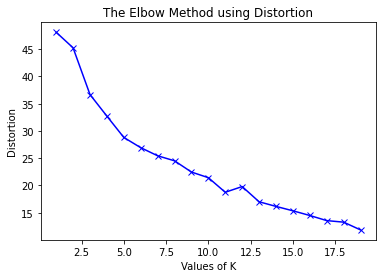

In [36]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

#can see the drastic change between 7.5 and 10

In [37]:
kmeans = KMeans(n_clusters = 8, random_state=55)
kmeans.fit(X)
y_pred = kmeans.predict(X)
print(y_pred)

[1 1 5 ... 0 1 1]


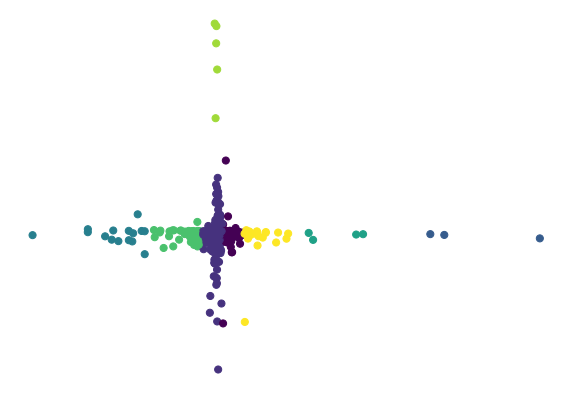

In [38]:
pca = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(10,7))
colours = 'rbgymrck'
plt.scatter(pca[:, 0], pca[:, 1], c=y_pred, s=50, cmap='viridis')

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [39]:
pd.Series(kmeans.labels_).value_counts() 

#tried the clusters from 7 to 11 and chose 8 because it has more and bigger variety of companies in the clusters

1    1057
0     132
5      39
7      23
3      15
6       5
4       4
2       3
dtype: int64

In [40]:
df['label'] = kmeans.labels_ #0-4(changable) above clusters #adding a label to a df
df['label'] = df['label'].astype(str)

In [41]:
centroids = df.groupby(['label']).mean() #grouping by label, shows avg 
    
#shows the highest 

In [42]:
centroids.style.background_gradient() 

#on this table we see the average value for each cluster and I'm distinguishing outliers, dropping some of the stocks 

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,PX_TO_BOOK_RATIO,quick_ratio,netmargin
label,,,,,,
0,0.366286,-46.024596,1.600656,4.428053,1.331518,0.053326
1,0.340288,25.418563,2.223834,5.141168,1.472170,0.082745
2,0.204240,-1666.416667,0.648155,2.826333,1.042577,-0.019333
3,0.308748,695.054598,0.176715,9.224267,2.475114,0.038600
4,0.160452,-759.988070,1.253740,5.276750,1.725844,0.061000
5,0.367096,236.632404,0.721021,8.287179,1.759652,0.044641
6,0.672718,34.316103,1.570711,-265.535600,1.408339,0.111800
7,0.294968,-247.238786,1.197466,11.987478,2.481493,0.022000


In [43]:
df_original[df['label'] == '1'] 

#imputing every cluster = outlier and checking what companies it has, if I should keep them or investigate separately 

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,assetsc,liabilitiesc,price,calendardate,datekey,sharesbas,equity,receivables,investmentsc,cashneq,assetsavg,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
30,ZTS,1.674000e+09,23.279,6.611000e+09,1.154500e+10,0.229,5.820000e+08,4.764120e+08,3.514,4.930000e+08,4.748000e+09,1.806000e+09,132.35,2019-12-31,12/31/2019,4.762992e+08,2.708000e+09,1.086000e+09,0.000000e+00,1.934000e+09,1.117150e+10,1.500000e+09,2.792,23.279,0.134270,0.294504,1.221921,3.514597,47.403295,1.672204,0.572629
65,ZNGA,4.044630e+08,2.931,7.165100e+08,3.660614e+09,-0.009,9.404900e+07,9.477330e+08,0.427,4.332000e+06,1.575670e+09,7.919680e+08,6.12,2019-12-31,12/31/2019,9.459225e+08,1.975430e+09,1.400780e+08,9.381730e+08,4.533290e+08,3.268752e+09,4.192500e+07,0.873,2.931,0.012826,0.010710,0.099426,0.427586,7.010309,1.933891,0.195735
180,ZBRA,1.192000e+09,7.490,1.377000e+09,4.711000e+09,0.142,2.650000e+08,5.392148e+07,22.106,1.880000e+08,1.195000e+09,1.404000e+09,255.44,2019-12-31,12/31/2019,5.392148e+07,1.839000e+09,6.130000e+08,0.000000e+00,3.000000e+07,4.674000e+09,5.440000e+08,11.572,7.490,0.116389,0.157718,4.914554,22.106219,22.073972,0.457977,0.292295
201,ZBH,2.125700e+09,2.485,8.221400e+09,2.463870e+10,0.151,4.233000e+08,2.060000e+08,10.319,3.368000e+08,4.723900e+09,3.441500e+09,149.68,2019-12-31,12/31/2019,2.056844e+08,1.238810e+10,1.363900e+09,0.000000e+00,6.179000e+08,2.436215e+10,1.131600e+09,4.218,2.485,0.046449,0.158442,2.058008,10.334767,35.486012,0.575854,0.333678
221,ZAYO,6.537000e+08,5.561,6.436700e+09,9.961200e+09,0.094,2.564000e+08,2.368000e+08,2.761,1.411000e+08,4.307000e+08,7.906000e+08,34.65,2019-12-31,12/31/2019,2.368297e+08,1.475700e+09,1.245000e+08,0.000000e+00,1.813000e+08,9.610350e+09,1.770000e+08,0.731,5.561,0.018418,0.215848,1.082634,2.760211,47.400821,0.386795,0.646177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40133,AAPL,9.181900e+10,14.382,1.082920e+11,3.406180e+11,0.242,3.051600e+10,4.415040e+09,20.797,2.556900e+10,1.632310e+11,1.021610e+11,289.80,2019-12-31,12/28/2019,4.443265e+09,8.953100e+10,3.994600e+10,6.739100e+10,3.977100e+10,3.358430e+11,5.752700e+10,14.489,14.382,0.171291,0.278472,6.867923,20.664759,20.001380,1.439962,0.317928
40154,AAP,2.112614e+09,3.090,2.764479e+09,1.124852e+10,0.045,1.583630e+08,6.942300e+07,30.431,1.261390e+08,5.695543e+09,4.477702e+09,158.35,2019-12-31,12/28/2019,6.925940e+07,3.549081e+09,6.894690e+08,0.000000e+00,4.186650e+08,1.117620e+10,4.868960e+08,8.544,3.090,0.043565,0.059708,2.286520,30.502923,18.533474,0.247478,0.245764
40175,AAON,1.225740e+08,8.872,0.000000e+00,3.714240e+08,0.131,2.734200e+07,5.206083e+07,2.354,2.143000e+07,1.875490e+08,5.602800e+07,49.41,2019-12-31,12/31/2019,5.209758e+07,2.901400e+08,6.739900e+07,2.900000e+04,4.437300e+07,3.463380e+08,5.371100e+07,1.168,8.872,0.155083,0.174833,0.524823,2.352777,42.303082,1.995449,0.000000
40238,AA,2.436000e+09,0.971,1.800000e+09,1.463100e+10,-0.124,2.620000e+08,1.855729e+08,13.127,-1.080000e+08,3.530000e+09,2.563000e+09,21.51,2019-12-31,12/31/2019,1.855729e+08,4.112000e+09,6.600000e+08,0.000000e+00,8.790000e+08,1.515150e+10,-1.125000e+09,1.654,0.971,-0.074250,-0.044335,1.411844,13.126915,13.004837,0.600468,0.123026


In [44]:
df_original[df['label'] == '2'] 

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,assetsc,liabilitiesc,price,calendardate,datekey,sharesbas,equity,receivables,investmentsc,cashneq,assetsavg,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
17724,MDU,1.378213e+09,2.091,2.358513e+09,7.683059e+09,0.069,339177000.0,200400000.0,6.877,130220000.0,1.297701e+09,8.664270e+08,29.71,2019-12-31,12/31/2019,200383869.0,2.847246e+09,836605000.0,0.000000e+00,66459000.0,7.571022e+09,335453000.0,-0.020,2.091,0.044307,0.094485,1.692636,6.877864,-1485.50,1.042285,0.306976
33576,CDAY,2.218000e+08,5.189,7.160000e+08,6.085700e+09,-0.007,26000000.0,144088431.0,1.539,19700000.0,3.623700e+09,3.371700e+09,67.88,2019-12-31,12/31/2019,143881411.0,1.882300e+09,80400000.0,3.204100e+09,281300000.0,6.377575e+09,78700000.0,-0.032,5.189,0.012340,0.088819,0.180704,1.541547,-2121.25,1.057567,0.117653
35984,BB,2.670000e+08,1.199,7.360000e+08,3.913000e+09,-0.120,39000000.0,548336000.0,0.487,-49000000.0,1.179000e+09,1.112000e+09,5.57,2019-12-31,11/30/2019,548336000.0,2.548000e+09,229000000.0,3.670000e+08,547000000.0,3.954500e+09,-60000000.0,-0.004,1.199,-0.015173,-0.183521,0.071124,0.486928,-1392.50,1.027878,0.188091


In [45]:
df_original[df['label'] == '3']

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,assetsc,liabilitiesc,price,calendardate,datekey,sharesbas,equity,receivables,investmentsc,cashneq,assetsavg,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
3943,TU,3.858000e+09,2.880,1.857400e+10,3.797500e+10,0.098,829000000.0,1.210000e+09,2.434,690000000.0,4.353000e+09,5.574000e+09,19.365,2019-12-31,12/31/2019,1.197348e+09,1.054800e+10,1.962000e+09,0.0,535000000.0,3.629275e+10,1.776000e+09,0.027,2.880,0.048935,0.178849,0.692363,3.222121,717.222222,0.447973,0.489111
4048,TTD,2.159440e+08,19.142,1.894500e+08,1.728761e+09,0.236,-28068000.0,4.504300e+07,4.794,52650000.0,1.449221e+09,9.303730e+08,259.780,2019-12-31,12/31/2019,4.513436e+07,6.125170e+08,1.166376e+09,124112000.0,130876000.0,1.366407e+09,1.083180e+08,0.440,19.142,0.079272,0.243813,-0.621877,4.784470,590.409091,1.527736,0.109587
9062,RYN,1.787920e+08,2.942,1.055129e+09,2.860996e+09,0.089,50060000.0,1.293135e+08,1.383,26127000.0,1.259750e+08,1.511860e+08,32.760,2019-12-31,12/31/2019,1.293135e+08,1.439981e+09,2.712700e+07,0.0,69968000.0,2.843334e+09,5.910500e+07,0.062,2.942,0.020787,0.146131,0.387121,1.382625,528.387097,0.642222,0.368798
9627,RNG,2.528650e+08,18.984,4.154050e+08,1.450747e+09,-0.100,-6162000.0,8.547600e+07,2.958,-20369000.0,5.355390e+08,2.807130e+08,168.670,2019-12-31,12/31/2019,8.393133e+07,7.457000e+08,1.299900e+08,0.0,343606000.0,1.122032e+09,-5.360700e+07,0.247,18.984,-0.047777,-0.080553,-0.073417,3.012761,682.874494,1.687118,0.286339
12458,PEN,1.452630e+08,11.804,8.229700e+07,6.659010e+08,0.067,4767000.0,3.495729e+07,4.155,10579000.0,4.631340e+08,9.104800e+07,164.270,2019-12-31,12/31/2019,3.491429e+07,4.858920e+08,1.059010e+08,116610000.0,72779000.0,6.084922e+08,4.845800e+07,0.131,11.804,0.079636,0.072827,0.136534,4.160560,1253.969466,3.243234,0.123587
14411,NVCR,9.923400e+07,38.294,1.635640e+08,4.794480e+08,0.043,6962000.0,9.929707e+07,0.999,153000.0,4.399470e+08,8.631100e+07,84.270,2019-12-31,12/31/2019,9.896853e+07,2.177900e+08,8.806100e+07,148769000.0,179416000.0,4.249375e+08,-7.230000e+06,0.166,38.294,-0.017014,0.001542,0.070346,1.002682,507.650602,4.822630,0.341151
15600,NEO,1.068680e+08,6.019,1.328750e+08,7.095060e+08,0.059,3359000.0,1.044330e+08,1.023,2321000.0,2.907380e+08,6.390400e+07,29.250,2019-12-31,12/31/2019,1.044076e+08,5.074080e+08,9.424200e+07,0.0,173016000.0,6.626678e+08,8.006000e+06,0.033,6.019,0.012081,0.021718,0.032172,1.023565,886.363636,4.182180,0.187278
19758,KTOS,1.851000e+08,3.289,3.426000e+08,1.186000e+09,0.016,-1000000.0,1.066000e+08,1.736,9300000.0,5.222000e+08,1.827000e+08,17.770,2019-12-31,12/29/2019,1.062696e+08,5.741000e+08,2.644000e+08,0.0,172600000.0,1.176700e+09,1.250000e+07,0.035,3.289,0.010623,0.050243,-0.009410,1.741796,507.714286,2.391899,0.288870
21354,IRWD,1.263010e+08,-22.383,4.554820e+08,4.027480e+08,0.379,27580000.0,1.568360e+08,0.805,49593000.0,3.068520e+08,4.092900e+07,13.310,2019-12-31,12/31/2019,1.568181e+08,-9.325100e+07,1.498430e+08,0.0,178273000.0,3.540875e+08,2.150500e+07,0.024,-22.383,0.060734,0.392657,0.175873,0.805398,554.583333,8.016712,1.130935
22128,IIVI,6.663310e+08,1.481,2.420049e+09,5.208209e+09,-0.147,81875000.0,9.084920e+07,7.334,-79065000.0,1.589189e+09,5.715990e+08,33.670,2019-12-31,12/31/2019,9.084920e+07,2.065697e+09,4.889020e+08,0.0,376840000.0,3.618661e+09,-7.154500e+07,0.038,1.481,-0.019771,-0.118657,0.901219,7.334473,886.052632,1.514597,0.464660


In [46]:
df_original[df['label'] == '4']

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,assetsc,liabilitiesc,price,calendardate,datekey,sharesbas,equity,receivables,investmentsc,cashneq,assetsavg,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
18736,LPX,5.370000e+08,3.516,3.840000e+08,1.835000e+09,-0.095,1.010000e+08,116700000.0,4.602,-7.300000e+07,6.190000e+08,2.440000e+08,29.67,2019-12-31,12/31/2019,117453425.0,9.910000e+08,1.640000e+08,0.0,195000000.0,2.015500e+09,-5.000000e+06,-0.033,3.516,-0.002481,-0.135940,0.859915,4.572025,-899.090909,1.471311,0.209264
22325,ICUI,3.155230e+08,2.809,0.000000e+00,1.692382e+09,0.065,4.886400e+07,20695000.0,15.246,1.782300e+07,8.821970e+08,2.484680e+08,187.12,2019-12-31,12/31/2019,20673333.0,1.377244e+09,2.022190e+08,23967000.0,268670000.0,1.641588e+09,1.010350e+08,-0.198,2.809,0.061547,0.056487,2.363625,15.262319,-945.050505,1.991629,0.000000
30317,D,4.475000e+09,2.131,3.789700e+10,1.038230e+11,0.225,1.495000e+09,823093381.0,5.437,1.221000e+09,6.088000e+09,9.939000e+09,82.82,2019-12-31,12/31/2019,823093381.0,3.199400e+10,2.645000e+09,0.0,166000000.0,1.017650e+11,1.358000e+09,-0.142,2.131,0.013345,0.272849,1.816319,5.436807,-583.239437,0.282825,0.365015
37968,AMRN,1.432770e+08,12.651,5.957300e+07,8.822090e+08,0.049,-8.936000e+06,359338000.0,0.399,5.490000e+06,8.550050e+08,2.422480e+08,21.44,2019-12-31,12/31/2019,358906887.0,6.082630e+08,1.164300e+08,0.0,648495000.0,6.278265e+08,-2.264500e+07,-0.035,12.651,-0.036069,0.038317,-0.024898,0.399204,-612.571429,3.157611,0.067527


In [47]:
df_original[df['label'] == '5']

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,assetsc,liabilitiesc,price,calendardate,datekey,sharesbas,equity,receivables,investmentsc,cashneq,assetsavg,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
86,ZM,1.882510e+08,25.289,6.479200e+07,1.289845e+09,0.076,3.655400e+07,2.766790e+08,0.680,1.055300e+07,1.095522e+09,3.338300e+08,76.30,2019-12-31,1/31/2020,2.764018e+08,8.339430e+08,1.204350e+08,5.720600e+08,2.831340e+08,1.136719e+09,2.175000e+07,0.487,25.289,0.019134,0.056058,0.132249,0.681077,156.673511,2.922532,0.050232
159,ZEN,2.298710e+08,18.769,5.887460e+08,1.514589e+09,-0.157,3.221100e+07,1.125170e+08,2.043,-3.230100e+07,6.928230e+08,4.786810e+08,76.63,2019-12-31,12/31/2019,1.121753e+08,4.579840e+08,1.278080e+08,2.869580e+08,1.965910e+08,1.446430e+09,-1.696530e+08,0.382,18.769,-0.117291,-0.140518,0.287149,2.049213,200.602094,1.277170,0.388717
1447,WING,5.318600e+07,-12.124,3.108690e+08,1.661130e+08,0.057,9.997000e+06,2.945700e+07,1.806,8.894000e+06,3.019000e+07,3.292900e+07,86.21,2019-12-31,12/28/2019,2.945337e+07,-2.094280e+08,5.175000e+06,0.000000e+00,1.763900e+07,1.589138e+08,2.047600e+07,0.547,-12.124,0.128850,0.167224,0.339418,1.805769,157.605119,0.692824,1.871431
1666,WEC,1.947500e+09,2.877,1.273500e+10,3.495180e+10,0.125,5.048000e+08,3.154000e+08,6.175,3.631000e+08,2.093600e+09,3.182700e+09,92.23,2019-12-31,12/31/2019,3.154356e+08,1.011340e+10,1.176500e+09,0.000000e+00,3.750000e+07,3.425010e+10,1.134000e+09,0.269,2.877,0.033109,0.186444,1.600327,6.174002,342.862454,0.381437,0.364359
2577,VICR,6.312500e+07,9.183,2.855000e+06,2.407270e+08,0.021,5.669000e+06,4.048300e+07,1.559,8.950000e+05,1.790660e+08,2.993000e+07,46.72,2019-12-31,12/31/2019,4.040406e+07,2.055620e+08,3.811500e+07,0.000000e+00,8.466800e+07,2.335610e+08,1.409800e+07,0.242,9.183,0.060361,0.014178,0.140308,1.562343,193.057851,4.102339,0.011860
4763,TNDM,1.083980e+08,18.066,2.038300e+07,3.261100e+08,0.024,1.944200e+07,5.922400e+07,1.830,2.143000e+06,2.761410e+08,9.939600e+07,59.61,2019-12-31,12/31/2019,5.909286e+07,1.949790e+08,4.658500e+07,1.252830e+08,5.117500e+07,2.721340e+08,-2.475300e+07,0.382,18.066,-0.090959,0.019770,0.329008,1.834367,156.047120,2.243984,0.062503
4805,TMUS,1.187800e+10,2.331,4.009800e+10,8.692100e+10,0.063,1.537000e+09,8.564009e+08,13.870,1.234000e+09,9.305000e+09,1.250600e+10,78.42,2019-12-31,12/31/2019,8.555748e+08,2.878900e+10,1.908000e+09,2.600000e+09,1.528000e+09,8.522275e+10,3.468000e+09,0.551,2.331,0.040693,0.103890,1.796453,13.883064,142.323049,0.482648,0.461315
5543,TDOC,1.564890e+08,5.976,4.654040e+08,1.602827e+09,-0.122,1.812200e+07,7.257277e+07,2.156,-1.558800e+07,5.880020e+08,9.018100e+07,83.72,2019-12-31,12/31/2019,7.238234e+07,1.014025e+09,5.694800e+07,2.711000e+06,5.143530e+08,1.572056e+09,-9.886400e+07,0.367,5.976,-0.062888,-0.099611,0.250365,2.161978,228.119891,6.365110,0.290364
10199,RDNT,3.008410e+08,6.728,1.181070e+09,1.646986e+09,0.035,2.171900e+07,4.990802e+07,6.028,2.377400e+07,2.411740e+08,3.274280e+08,20.30,2019-12-31,12/31/2019,5.027183e+07,1.516850e+08,1.560050e+08,0.000000e+00,4.016500e+07,1.596908e+09,1.475600e+07,0.084,6.728,0.009240,0.079025,0.432031,5.984286,241.666667,0.599124,0.717110
12520,PEG,2.478000e+09,1.979,1.622300e+10,4.773000e+10,0.176,6.700000e+08,5.040000e+08,4.917,5.070000e+08,3.231000e+09,5.047000e+09,59.05,2019-12-31,12/31/2019,5.057265e+08,1.508900e+10,1.313000e+09,0.000000e+00,1.470000e+08,4.664525e+10,1.693000e+09,0.423,1.979,0.036295,0.204600,1.324827,4.899882,139.598109,0.289281,0.339891


In [48]:
df_original[df['label'] == '6']

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,assetsc,liabilitiesc,price,calendardate,datekey,sharesbas,equity,receivables,investmentsc,cashneq,assetsavg,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
16491,MSCI,406606000.0,-285.081,3.236070e+09,4.204439e+09,0.302,243643000.0,84803000.0,4.795,199429000.0,2.081777e+09,9.007860e+08,258.18,2019-12-31,12/31/2019,84707270.0,-76714000.0,499268000.0,0.0,1.506567e+09,3.601209e+09,563648000.0,7.747,-285.081,0.156516,0.490472,2.876294,4.800131,33.326449,2.226761,0.769679
24358,GSHD,13798000.0,-170.826,4.616100e+07,6.462800e+07,-0.058,4748000.0,15218000.0,0.907,-2161000.0,2.673300e+07,1.341000e+07,42.40,2019-12-31,12/31/2019,36288491.0,-9007000.0,20500000.0,0.0,1.526000e+07,4.888575e+07,3567000.0,1.153,-170.826,0.072966,-0.156617,0.130840,0.380231,36.773634,2.666667,0.714257
25380,FUN,257246000.0,-315.216,2.163983e+09,2.581145e+09,0.011,13902000.0,56364000.0,4.564,16812000.0,2.941810e+08,3.241380e+08,55.44,2019-12-31,12/31/2019,56663821.0,-9966000.0,63106000.0,0.0,1.822520e+08,2.476108e+09,172363000.0,1.284,-315.216,0.069610,0.065354,0.245342,4.539863,43.177570,0.756955,0.838381
33001,CHH,268084000.0,-245.171,8.728830e+08,1.386672e+09,0.157,79579000.0,55730708.0,4.810,68643000.0,2.365890e+08,3.258880e+08,103.43,2019-12-31,12/31/2019,55730708.0,-23511000.0,141566000.0,25404000.0,3.376600e+07,1.287257e+09,222878000.0,3.896,-245.171,0.173142,0.256050,1.427920,4.810346,26.547741,0.615966,0.629481
39458,ADSK,899300000.0,-311.384,2.544600e+09,6.179300e+09,0.147,698200000.0,220000000.0,4.088,133800000.0,2.659300e+09,3.219200e+09,196.85,2019-12-31,1/31/2020,220033002.0,-139100000.0,652300000.0,69000000.0,1.774700e+09,5.224275e+09,214500000.0,6.199,-311.384,0.041058,0.148782,3.173160,4.087114,31.755122,0.775348,0.411794


In [49]:
df_original[df['label'] == '7']

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,assetsc,liabilitiesc,price,calendardate,datekey,sharesbas,equity,receivables,investmentsc,cashneq,assetsavg,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET
3812,TXG,7.528900e+07,17.456,2.971900e+07,6.059230e+08,-0.095,6.700000e+06,39091366.0,1.926,-8080000.0,4.808400e+08,6.304900e+07,76.250,2019-12-31,12/31/2019,96169954.0,4.200830e+08,3.337100e+07,0.000000e+00,4.764930e+08,3.651165e+08,-3.125100e+07,-0.208,17.456,-0.085592,-0.107320,0.069668,0.782874,-366.586538,8.086790,0.049047
5648,TCMD,5.706300e+07,11.409,1.658800e+07,1.517520e+08,0.075,8.900000e+04,19064162.0,2.993,6049000.0,1.083350e+08,2.142800e+07,67.510,2019-12-31,12/31/2019,19028450.0,1.125950e+08,3.762800e+07,3.061100e+07,2.277000e+07,1.327200e+08,1.097100e+07,-0.155,11.409,0.082663,0.106006,0.004677,2.998825,-435.548387,4.247200,0.109310
8899,SAIA,4.430650e+08,2.963,2.416890e+08,1.415693e+09,0.048,6.557800e+07,26000000.0,17.041,27430000.0,2.323790e+08,2.412460e+08,93.120,2019-12-31,12/31/2019,25936012.0,8.152260e+08,1.961190e+08,0.000000e+00,2.480000e+05,1.359236e+09,1.137190e+08,-0.314,2.963,0.083664,0.061910,2.528453,17.083004,-296.560510,0.813970,0.170721
9485,ROKU,4.112300e+08,22.530,4.013020e+08,1.470234e+09,-0.038,-1.058000e+07,118680000.0,3.465,-17384000.0,9.256630e+08,3.583010e+08,133.900,2019-12-31,12/31/2019,117515417.0,6.984260e+08,3.326730e+08,0.000000e+00,5.173330e+08,9.541240e+08,-5.993700e+07,-0.551,22.530,-0.062819,-0.042273,-0.090031,3.499371,-243.012704,2.372324,0.272951
10533,QTWO,8.684000e+07,10.291,4.700030e+08,1.009434e+09,-0.180,1.895000e+06,48235000.0,1.800,-21858000.0,1.863350e+08,1.329660e+08,81.080,2019-12-31,12/31/2019,48155730.0,3.794120e+08,3.850300e+07,3.232500e+07,1.035620e+08,8.573268e+08,-7.087700e+07,-0.292,10.291,-0.082672,-0.251704,0.039351,1.803316,-277.671233,1.311538,0.465610
10775,PXD,2.643000e+09,2.069,2.595000e+09,1.906700e+10,0.130,8.280000e+08,164000000.0,16.116,481000000.0,2.191000e+09,2.496000e+09,151.370,2019-12-31,12/31/2019,165646527.0,1.211900e+10,1.035000e+09,1.870000e+08,7.050000e+08,1.840150e+10,7.560000e+08,-0.629,2.069,0.041084,0.181990,4.998596,15.955662,-240.651828,0.772035,0.136099
11618,PODD,2.093940e+08,139.445,8.879000e+08,1.142900e+09,0.024,4.693300e+07,62416895.0,3.355,18128000.0,5.910000e+08,1.577000e+08,171.200,2019-12-31,12/31/2019,61821566.0,7.590000e+07,6.930000e+07,1.624000e+08,2.137000e+08,1.085406e+09,1.160000e+07,-1.078,139.445,0.010687,0.086574,0.759169,3.387070,-158.812616,2.824350,0.776883
12079,PINS,3.998980e+08,5.142,1.733920e+08,2.393317e+09,-0.089,9.558000e+06,420473000.0,0.951,-43187000.0,2.067234e+09,1.761570e+08,18.640,2019-12-31,12/31/2019,558226294.0,2.023705e+09,3.163670e+08,1.063679e+09,6.750050e+08,2.050551e+09,-1.361371e+09,-0.079,5.142,-0.663905,-0.107995,0.017122,0.716373,-235.949367,11.666020,0.072448
14242,NWE,3.281350e+08,1.773,2.253196e+09,5.910702e+09,0.183,4.285900e+07,50450000.0,6.504,84651000.0,3.017270e+08,3.342670e+08,71.670,2019-12-31,12/31/2019,50446835.0,2.039094e+09,1.674050e+08,0.000000e+00,1.207000e+07,5.785493e+09,2.021200e+08,-0.383,1.773,0.034936,0.257976,0.849587,6.504571,-187.127937,0.536921,0.381206
18925,LNN,1.093930e+08,3.565,1.413380e+08,5.268110e+08,0.076,1.541000e+06,10795000.0,10.134,12276000.0,3.166310e+08,8.480100e+07,90.220,2019-12-31,11/30/2019,10786339.0,2.730000e+08,7.931700e+07,0.000000e+00,1.209100e+08,5.081800e+08,9.305000e+06,-0.202,3.565,0.018310,0.112219,0.142866,10.141810,-446.633663,2.361140,0.268290


----------------------------------------------------------------------------------------------------


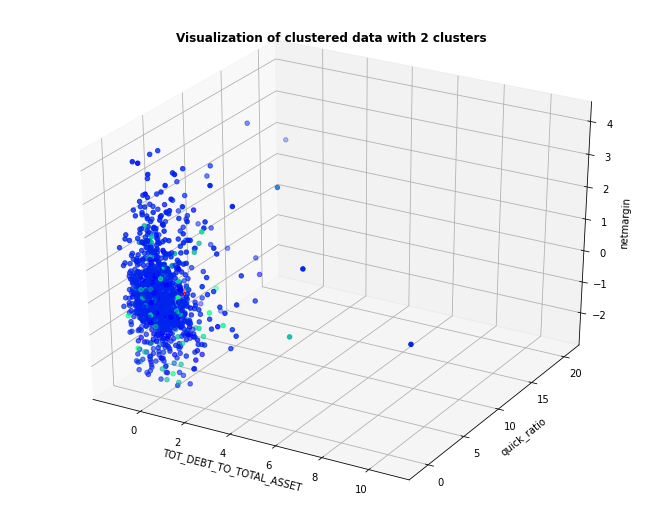

----------------------------------------------------------------------------------------------------


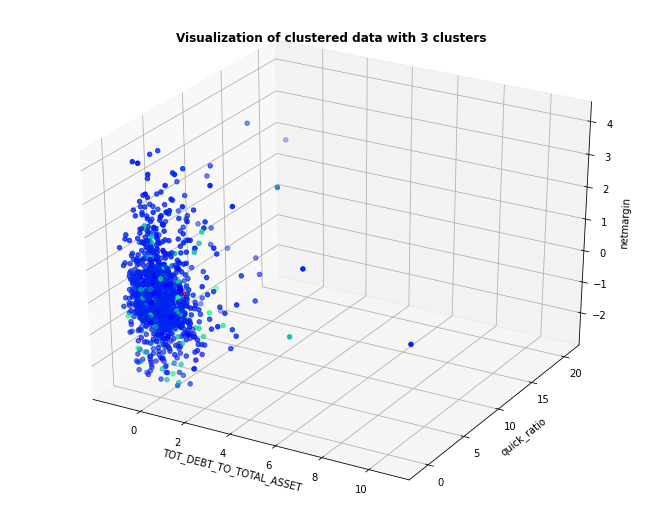

In [50]:
clusters = [2,3]

for cluster in clusters:
    
    print('-'*100)
    
    kmeans = KMeans(n_clusters= 8, random_state=55).fit(X)
    
    # define the cluster centers
    cluster_centers = kmeans.cluster_centers_
    C1 = cluster_centers[:, 0]
    C2 = cluster_centers[:, 4]
    C3 = cluster_centers[:, 5]


    # create a new plot
    fig = plt.figure(figsize = (9, 7))
    ax = Axes3D(fig)

    # take the scaled data in this example.
    x = X_train_robust[:,0]
    y = X_train_robust[:,4]
    z = X_train_robust[:,5]

    # define the axes labels
    column_names = df.columns
    ax.set_xlabel(column_names[0])
    ax.set_ylabel(column_names[4])
    ax.set_zlabel(column_names[5])

    # create a new plot
    ax.scatter(x, y, z, c = kmeans.labels_.astype(float), cmap='winter')
    ax.scatter(C1, C2, C3, marker="x", color='r')

    plt.title('Visualization of clustered data with {} clusters'.format(cluster), fontweight='bold')

    plt.show()

----------------------------------------------------------------------------------------------------


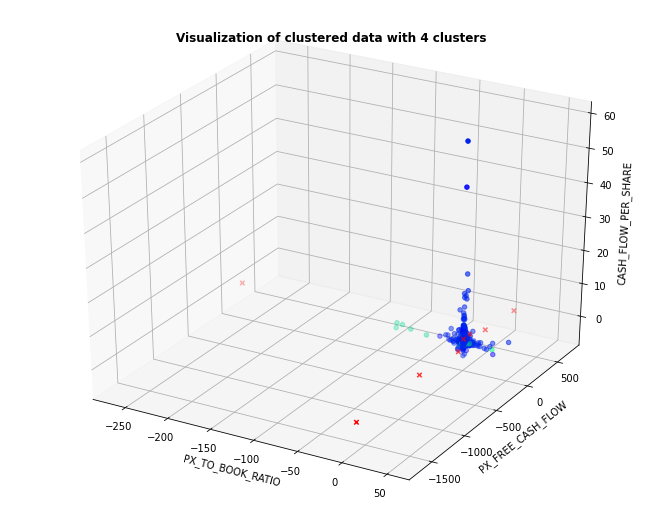

----------------------------------------------------------------------------------------------------


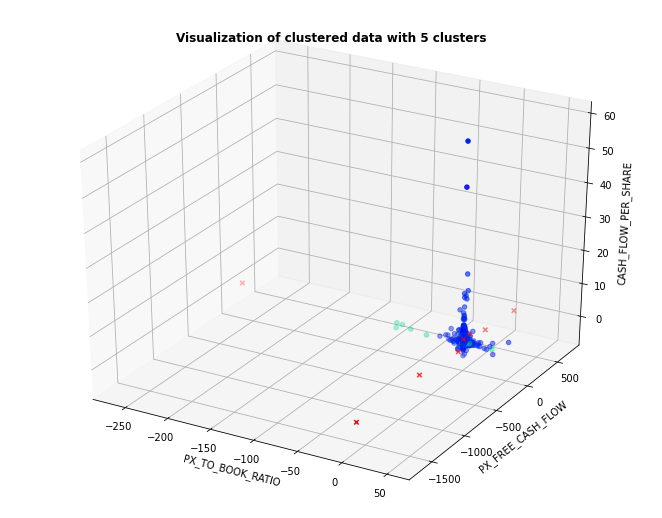

In [51]:
clusters = [4,5]

for cluster in clusters:
    
    print('-'*100)
    
    kmeans = KMeans(n_clusters= 8, random_state=55).fit(X)
    
    # define the cluster centers
    cluster_centers = kmeans.cluster_centers_
    C1 = cluster_centers[:, 3]
    C2 = cluster_centers[:, 1]
    C3 = cluster_centers[:, 2]


    # create a new plot
    fig = plt.figure(figsize = (9, 7))
    ax = Axes3D(fig)

    # take the scaled data in this example.
    x = X_train_robust[:,3]
    y = X_train_robust[:,1]
    z = X_train_robust[:,2]

    # define the axes labels
    column_names = df.columns
    ax.set_xlabel(column_names[3])
    ax.set_ylabel(column_names[1])
    ax.set_zlabel(column_names[2])

    # create a new plot
    ax.scatter(x, y, z, c = kmeans.labels_.astype(float), cmap='winter')
    ax.scatter(C1, C2, C3, marker="x", color='r')

    plt.title('Visualization of clustered data with {} clusters'.format(cluster), fontweight='bold')

    plt.show()

In [52]:
from sklearn import datasets, metrics

In [53]:
print(metrics.silhouette_score(X, y_pred, metric='euclidean')) 

#closer to 1, clustering is better. Test with cluster numbers:6, 7

0.6188135629047118


In [54]:
#let's see the other method of clustering: GaussianMixture, all the steps that i did above can be applied here too.
#spherical and diagonal covariances didn't perform better than the full one, the silhouette score was worse in both of them

gauss = GaussianMixture(n_components=4, random_state=10)
gauss.fit_predict(X)
y_pred = gauss.predict(X)
print(y_pred)

[3 0 1 ... 3 0 0]


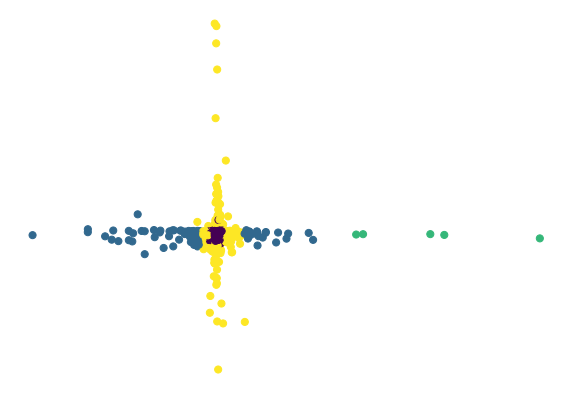

In [55]:
pca = PCA(n_components=3).fit_transform(X)

plt.figure(figsize=(10,7))
colours = 'rbgym'
plt.scatter(pca[:, 0], pca[:, 1], c=y_pred, s=50, cmap='viridis')

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [56]:
prob_df = pd.DataFrame(gauss.predict_proba(X))
prob_df.shape

(1278, 4)

In [57]:
print(metrics.silhouette_score(X, y_pred, metric='euclidean')) 


#2 clusters is better for silhouette score.

0.4157819268959252


In [58]:
df_original['label'] = kmeans.labels_ #adding a new column 'label' to the original df

In [59]:
from ipywidgets import interact

In [60]:
px.scatter(data_frame=df_original, x='RETURN_ON_ASSET', y='quick_ratio', color = 'label', hover_data=['ticker', 'netmargin', 'PX_FREE_CASH_FLOW'])

In [61]:
@interact
def plotting(x=df_original.columns, y = df_original.columns):
    fig = px.scatter(data_frame=df_original, x= x, y= y, color = 'label', hover_data=['ticker', 'PX_TO_BOOK_RATIO', 'CASH_FLOW_PER_SHARE'])
    fig.show()

interactive(children=(Dropdown(description='x', options=('ticker', 'revenue', 'pb', 'debt', 'assets', 'netmarg…

<Figure size 648x504 with 0 Axes>

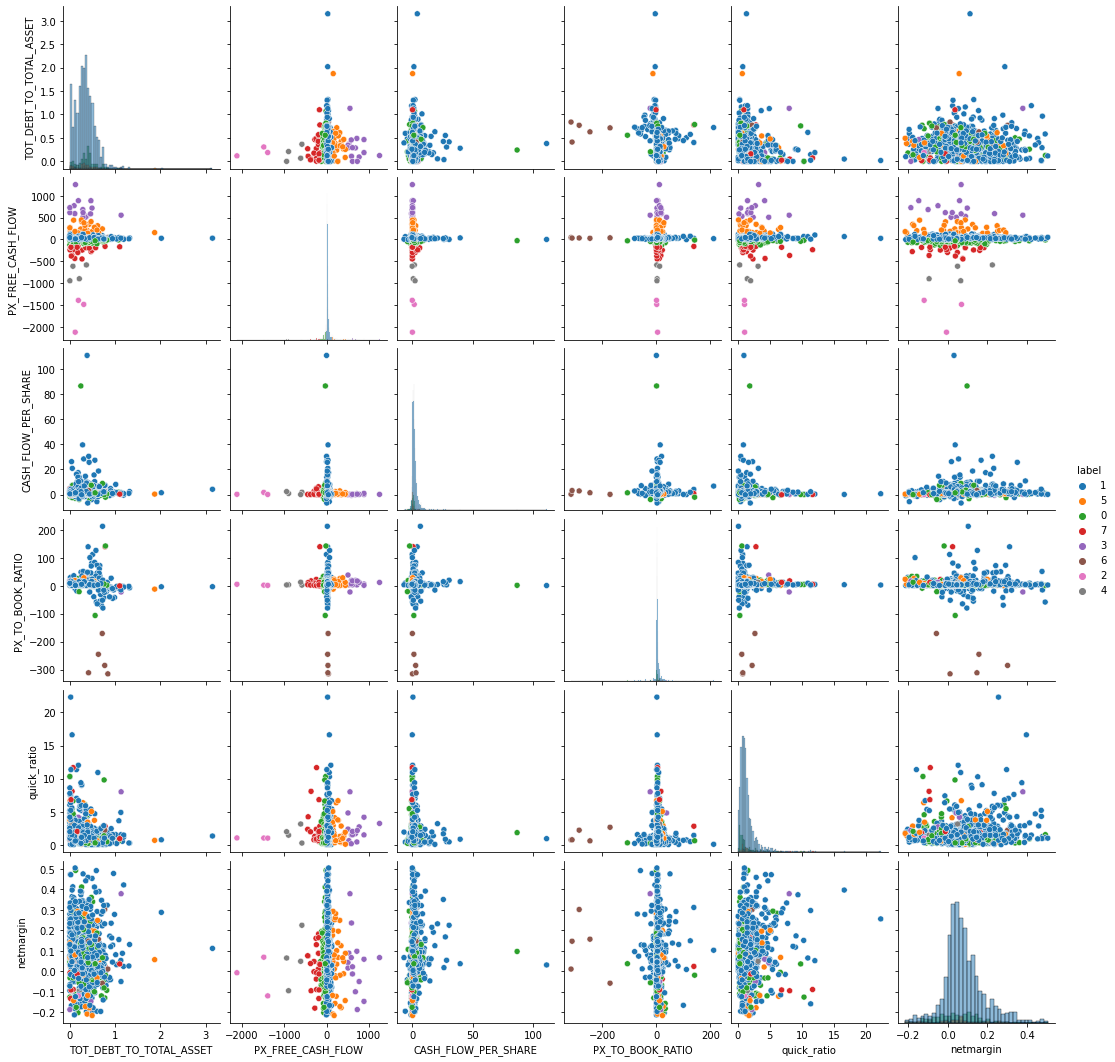

<Figure size 648x504 with 0 Axes>

In [62]:
sns.pairplot(df, hue="label", diag_kind="hist")
plt.figure(figsize=(9,7))
#very interesting.. We can actually see the clusters very distintcly at some plots.
#amazing tool for futher investigation. 
#on price per cash flow column can see distinguished clusters.

In [63]:
df_original[df['label'] == '1']

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,assetsc,liabilitiesc,price,calendardate,datekey,sharesbas,equity,receivables,investmentsc,cashneq,assetsavg,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET,label
30,ZTS,1.674000e+09,23.279,6.611000e+09,1.154500e+10,0.229,5.820000e+08,4.764120e+08,3.514,4.930000e+08,4.748000e+09,1.806000e+09,132.35,2019-12-31,12/31/2019,4.762992e+08,2.708000e+09,1.086000e+09,0.000000e+00,1.934000e+09,1.117150e+10,1.500000e+09,2.792,23.279,0.134270,0.294504,1.221921,3.514597,47.403295,1.672204,0.572629,1
65,ZNGA,4.044630e+08,2.931,7.165100e+08,3.660614e+09,-0.009,9.404900e+07,9.477330e+08,0.427,4.332000e+06,1.575670e+09,7.919680e+08,6.12,2019-12-31,12/31/2019,9.459225e+08,1.975430e+09,1.400780e+08,9.381730e+08,4.533290e+08,3.268752e+09,4.192500e+07,0.873,2.931,0.012826,0.010710,0.099426,0.427586,7.010309,1.933891,0.195735,1
180,ZBRA,1.192000e+09,7.490,1.377000e+09,4.711000e+09,0.142,2.650000e+08,5.392148e+07,22.106,1.880000e+08,1.195000e+09,1.404000e+09,255.44,2019-12-31,12/31/2019,5.392148e+07,1.839000e+09,6.130000e+08,0.000000e+00,3.000000e+07,4.674000e+09,5.440000e+08,11.572,7.490,0.116389,0.157718,4.914554,22.106219,22.073972,0.457977,0.292295,1
201,ZBH,2.125700e+09,2.485,8.221400e+09,2.463870e+10,0.151,4.233000e+08,2.060000e+08,10.319,3.368000e+08,4.723900e+09,3.441500e+09,149.68,2019-12-31,12/31/2019,2.056844e+08,1.238810e+10,1.363900e+09,0.000000e+00,6.179000e+08,2.436215e+10,1.131600e+09,4.218,2.485,0.046449,0.158442,2.058008,10.334767,35.486012,0.575854,0.333678,1
221,ZAYO,6.537000e+08,5.561,6.436700e+09,9.961200e+09,0.094,2.564000e+08,2.368000e+08,2.761,1.411000e+08,4.307000e+08,7.906000e+08,34.65,2019-12-31,12/31/2019,2.368297e+08,1.475700e+09,1.245000e+08,0.000000e+00,1.813000e+08,9.610350e+09,1.770000e+08,0.731,5.561,0.018418,0.215848,1.082634,2.760211,47.400821,0.386795,0.646177,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40133,AAPL,9.181900e+10,14.382,1.082920e+11,3.406180e+11,0.242,3.051600e+10,4.415040e+09,20.797,2.556900e+10,1.632310e+11,1.021610e+11,289.80,2019-12-31,12/28/2019,4.443265e+09,8.953100e+10,3.994600e+10,6.739100e+10,3.977100e+10,3.358430e+11,5.752700e+10,14.489,14.382,0.171291,0.278472,6.867923,20.664759,20.001380,1.439962,0.317928,1
40154,AAP,2.112614e+09,3.090,2.764479e+09,1.124852e+10,0.045,1.583630e+08,6.942300e+07,30.431,1.261390e+08,5.695543e+09,4.477702e+09,158.35,2019-12-31,12/28/2019,6.925940e+07,3.549081e+09,6.894690e+08,0.000000e+00,4.186650e+08,1.117620e+10,4.868960e+08,8.544,3.090,0.043565,0.059708,2.286520,30.502923,18.533474,0.247478,0.245764,1
40175,AAON,1.225740e+08,8.872,0.000000e+00,3.714240e+08,0.131,2.734200e+07,5.206083e+07,2.354,2.143000e+07,1.875490e+08,5.602800e+07,49.41,2019-12-31,12/31/2019,5.209758e+07,2.901400e+08,6.739900e+07,2.900000e+04,4.437300e+07,3.463380e+08,5.371100e+07,1.168,8.872,0.155083,0.174833,0.524823,2.352777,42.303082,1.995449,0.000000,1
40238,AA,2.436000e+09,0.971,1.800000e+09,1.463100e+10,-0.124,2.620000e+08,1.855729e+08,13.127,-1.080000e+08,3.530000e+09,2.563000e+09,21.51,2019-12-31,12/31/2019,1.855729e+08,4.112000e+09,6.600000e+08,0.000000e+00,8.790000e+08,1.515150e+10,-1.125000e+09,1.654,0.971,-0.074250,-0.044335,1.411844,13.126915,13.004837,0.600468,0.123026,1


In [64]:
from sklearn.manifold import TSNE
import time

In [87]:
X

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,PX_TO_BOOK_RATIO,quick_ratio,netmargin,label
30,0.572629,47.403295,1.221921,23.279,1.672204,0.229,1
65,0.195735,7.010309,0.099426,2.931,1.933891,-0.009,1
86,0.050232,156.673511,0.132249,25.289,2.922532,0.076,5
159,0.388717,200.602094,0.287149,18.769,1.277170,-0.157,5
180,0.292295,22.073972,4.914554,7.490,0.457977,0.142,1
...,...,...,...,...,...,...,...
40154,0.245764,18.533474,2.286520,3.090,0.247478,0.045,1
40175,0.000000,42.303082,0.524823,8.872,1.995449,0.131,1
40217,0.557446,-31.481888,1.369682,-106.470,0.313145,0.037,0
40238,0.123026,13.004837,1.411844,0.971,0.600468,-0.124,1


In [91]:
df_original

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,assetsc,liabilitiesc,price,calendardate,datekey,sharesbas,equity,receivables,investmentsc,cashneq,assetsavg,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET,label
30,ZTS,1.674000e+09,23.279,6.611000e+09,1.154500e+10,0.229,582000000.0,476412000.0,3.514,493000000.0,4.748000e+09,1.806000e+09,132.35,2019-12-31,12/31/2019,476299250.0,2.708000e+09,1.086000e+09,0.000000e+00,1.934000e+09,1.117150e+10,1.500000e+09,2.792,23.279,0.134270,0.294504,1.221921,3.514597,47.403295,1.672204,0.572629,1
65,ZNGA,4.044630e+08,2.931,7.165100e+08,3.660614e+09,-0.009,94049000.0,947733000.0,0.427,4332000.0,1.575670e+09,7.919680e+08,6.12,2019-12-31,12/31/2019,945922482.0,1.975430e+09,1.400780e+08,9.381730e+08,4.533290e+08,3.268752e+09,4.192500e+07,0.873,2.931,0.012826,0.010710,0.099426,0.427586,7.010309,1.933891,0.195735,1
86,ZM,1.882510e+08,25.289,6.479200e+07,1.289845e+09,0.076,36554000.0,276679009.0,0.680,10553000.0,1.095522e+09,3.338300e+08,76.30,2019-12-31,1/31/2020,276401815.0,8.339430e+08,1.204350e+08,5.720600e+08,2.831340e+08,1.136719e+09,2.175000e+07,0.487,25.289,0.019134,0.056058,0.132249,0.681077,156.673511,2.922532,0.050232,5
159,ZEN,2.298710e+08,18.769,5.887460e+08,1.514589e+09,-0.157,32211000.0,112517000.0,2.043,-32301000.0,6.928230e+08,4.786810e+08,76.63,2019-12-31,12/31/2019,112175267.0,4.579840e+08,1.278080e+08,2.869580e+08,1.965910e+08,1.446430e+09,-1.696530e+08,0.382,18.769,-0.117291,-0.140518,0.287149,2.049213,200.602094,1.277170,0.388717,5
180,ZBRA,1.192000e+09,7.490,1.377000e+09,4.711000e+09,0.142,265000000.0,53921478.0,22.106,188000000.0,1.195000e+09,1.404000e+09,255.44,2019-12-31,12/31/2019,53921478.0,1.839000e+09,6.130000e+08,0.000000e+00,3.000000e+07,4.674000e+09,5.440000e+08,11.572,7.490,0.116389,0.157718,4.914554,22.106219,22.073972,0.457977,0.292295,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40154,AAP,2.112614e+09,3.090,2.764479e+09,1.124852e+10,0.045,158363000.0,69423000.0,30.431,126139000.0,5.695543e+09,4.477702e+09,158.35,2019-12-31,12/28/2019,69259396.0,3.549081e+09,6.894690e+08,0.000000e+00,4.186650e+08,1.117620e+10,4.868960e+08,8.544,3.090,0.043565,0.059708,2.286520,30.502923,18.533474,0.247478,0.245764,1
40175,AAON,1.225740e+08,8.872,0.000000e+00,3.714240e+08,0.131,27342000.0,52060833.0,2.354,21430000.0,1.875490e+08,5.602800e+07,49.41,2019-12-31,12/31/2019,52097581.0,2.901400e+08,6.739900e+07,2.900000e+04,4.437300e+07,3.463380e+08,5.371100e+07,1.168,8.872,0.155083,0.174833,0.524823,2.352777,42.303082,1.995449,0.000000,1
40217,AAL,1.131300e+10,-106.470,3.344400e+10,5.999500e+10,0.037,600000000.0,438057971.0,25.825,729000000.0,8.206000e+09,1.831100e+10,28.68,2019-12-31,12/31/2019,438057971.0,-1.180000e+08,1.750000e+09,3.546000e+09,4.380000e+08,6.098100e+10,1.686000e+09,-0.911,-106.470,0.027648,0.064439,1.369682,25.825349,-31.481888,0.313145,0.557446,0
40238,AA,2.436000e+09,0.971,1.800000e+09,1.463100e+10,-0.124,262000000.0,185572917.0,13.127,-108000000.0,3.530000e+09,2.563000e+09,21.51,2019-12-31,12/31/2019,185572917.0,4.112000e+09,6.600000e+08,0.000000e+00,8.790000e+08,1.515150e+10,-1.125000e+09,1.654,0.971,-0.074250,-0.044335,1.411844,13.126915,13.004837,0.600468,0.123026,1


In [107]:
time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=500)
tsne_results = tsne.fit_transform(df_scaled)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1278 samples in 0.001s...
[t-SNE] Computed neighbors for 1278 samples in 0.084s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1278
[t-SNE] Computed conditional probabilities for sample 1278 / 1278
[t-SNE] Mean sigma: 0.381204
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.139435
[t-SNE] KL divergence after 500 iterations: 0.933218
t-SNE done! Time elapsed: 5.9610419273376465 seconds


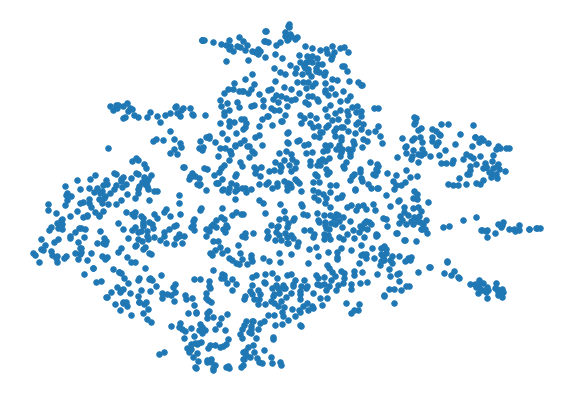

In [108]:
plt.figure(figsize=(10,7))
colours = 'rbgym'
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=30, cmap='viridis')

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

#no clustering yet, just in 2 dimensions

In [117]:
kmeans = KMeans(n_clusters = 8, random_state=55)
kmeans.fit(tsne_results)
y_pred = kmeans.predict(tsne_results)
print(y_pred)

[3 5 0 ... 4 6 3]


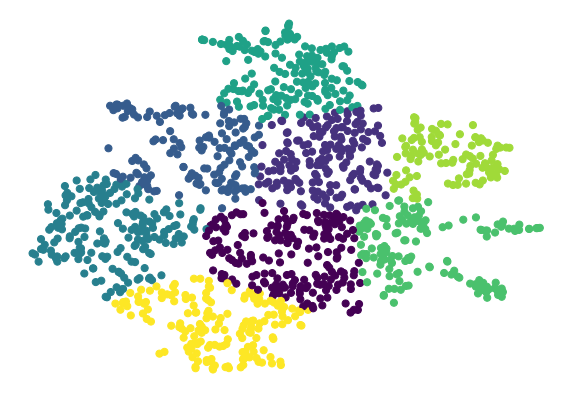

In [118]:
#tsne = PCA(n_components=2).fit_transform(tsne_results)

plt.figure(figsize=(10,7))
colours = 'rbgymrck'
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_pred, s=50, cmap='viridis')

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [119]:
import umap
import time


In [159]:
time_start = time.time()

umap_results = umap.UMAP(n_neighbors=8,
                      min_dist=0.4,
                      metric='euclidean').fit_transform(df_scaled)

print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))

UMAP done! Time elapsed: 4.775752067565918 seconds


In [160]:
kmeans = KMeans(n_clusters = 6, random_state=55)
kmeans.fit(umap_results)
y_pred = kmeans.predict(umap_results)
print(y_pred)

[2 5 5 ... 4 0 2]


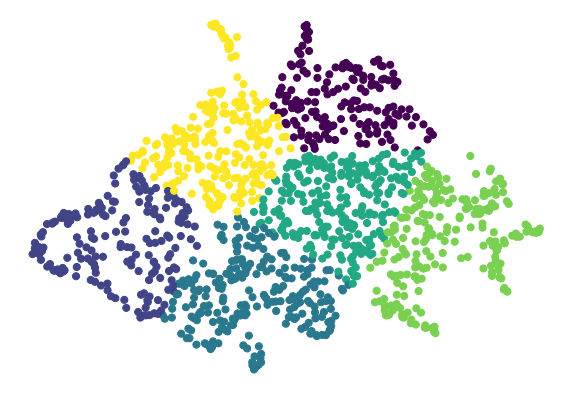

In [161]:
plt.figure(figsize=(10,7))
colours = 'rbgymrck'
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=y_pred, s=50, cmap='viridis')

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [163]:
df['y_pred'] = y_pred

In [167]:
df[df.y_pred == 2]

,TOT_DEBT_TO_TOTAL_ASSET,PX_FREE_CASH_FLOW,CASH_FLOW_PER_SHARE,PX_TO_BOOK_RATIO,quick_ratio,netmargin,label,y_pred
30,0.572629,47.403295,1.221921,23.279,1.672204,0.229,1,2
180,0.292295,22.073972,4.914554,7.490,0.457977,0.142,1,2
201,0.333678,35.486012,2.058008,2.485,0.575854,0.151,1,2
429,0.284575,6.286445,2.026012,1.427,1.526929,0.345,1,2
602,0.409531,-34.244876,1.346331,2.515,0.405648,0.104,0,2
...,...,...,...,...,...,...,...,...
39698,0.435888,38.422921,0.421380,3.876,1.133485,0.139,1,2
39882,0.267194,34.143082,1.366164,4.907,0.880512,0.126,1,2
40029,0.748785,10.266698,2.214602,-16.022,2.909978,0.322,1,2
40133,0.317928,20.001380,6.867923,14.382,1.439962,0.242,1,2


In [187]:
ind = df.index.tolist() #bold numbers on the left, count

In [191]:
df_new = df_original.loc[ind]

In [192]:
df_new['y_pred']=y_pred

In [193]:
df_new[df_new.y_pred == 2]

,ticker,revenue,pb,debt,assets,netmargin,ncfo,shareswa,sps,opinc,assetsc,liabilitiesc,price,calendardate,datekey,sharesbas,equity,receivables,investmentsc,cashneq,assetsavg,netinccmn,fcfps,PX_TO_BOOK_RATIO,RETURN_ON_ASSET,OPER_MARGIN,CASH_FLOW_PER_SHARE,REVENUE_PER_SHARE,PX_FREE_CASH_FLOW,quick_ratio,TOT_DEBT_TO_TOTAL_ASSET,label,y_pred
30,ZTS,1.674000e+09,23.279,6.611000e+09,1.154500e+10,0.229,5.820000e+08,4.764120e+08,3.514,4.930000e+08,4.748000e+09,1.806000e+09,132.350,2019-12-31,12/31/2019,4.762992e+08,2.708000e+09,1.086000e+09,0.000000e+00,1.934000e+09,1.117150e+10,1.500000e+09,2.792,23.279,0.134270,0.294504,1.221921,3.514597,47.403295,1.672204,0.572629,1,2
180,ZBRA,1.192000e+09,7.490,1.377000e+09,4.711000e+09,0.142,2.650000e+08,5.392148e+07,22.106,1.880000e+08,1.195000e+09,1.404000e+09,255.440,2019-12-31,12/31/2019,5.392148e+07,1.839000e+09,6.130000e+08,0.000000e+00,3.000000e+07,4.674000e+09,5.440000e+08,11.572,7.490,0.116389,0.157718,4.914554,22.106219,22.073972,0.457977,0.292295,1,2
201,ZBH,2.125700e+09,2.485,8.221400e+09,2.463870e+10,0.151,4.233000e+08,2.060000e+08,10.319,3.368000e+08,4.723900e+09,3.441500e+09,149.680,2019-12-31,12/31/2019,2.056844e+08,1.238810e+10,1.363900e+09,0.000000e+00,6.179000e+08,2.436215e+10,1.131600e+09,4.218,2.485,0.046449,0.158442,2.058008,10.334767,35.486012,0.575854,0.333678,1,2
429,XRX,2.371000e+09,1.427,4.282000e+09,1.504700e+10,0.345,4.380000e+08,2.161883e+08,10.967,3.090000e+08,6.140000e+09,3.435000e+09,36.870,2019-12-31,12/31/2019,2.161883e+08,5.587000e+09,2.394000e+09,1.110000e+08,2.740000e+09,1.479950e+10,1.353000e+09,5.865,1.427,0.091422,0.130325,2.026012,10.967293,6.286445,1.526929,0.284575,1,2
602,XEL,2.798000e+09,2.515,2.066000e+10,5.044800e+10,0.104,7.060000e+08,5.250000e+08,5.330,4.500000e+08,3.113000e+09,4.568000e+09,63.490,2019-12-31,12/31/2019,5.243881e+08,1.323900e+10,1.550000e+09,5.500000e+07,2.480000e+08,4.928050e+10,1.372000e+09,-1.854,2.515,0.027841,0.160829,1.346331,5.335743,-34.244876,0.405648,0.409531,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39698,ACIW,3.999200e+08,3.876,1.419921e+09,3.257534e+09,0.139,4.871100e+07,1.156890e+08,3.457,1.024130e+08,9.203760e+08,6.119500e+08,37.885,2019-12-31,12/31/2019,1.155986e+08,1.129968e+09,5.722380e+08,0.000000e+00,1.213980e+08,3.040688e+09,6.706200e+07,0.986,3.876,0.022055,0.256084,0.421380,3.459556,38.422921,1.133485,0.435888,1,2
39882,ABT,8.314000e+09,4.907,1.813900e+10,6.788700e+10,0.126,2.416000e+09,1.768045e+09,4.702,1.389000e+09,1.566700e+10,1.086300e+10,86.860,2019-12-31,12/31/2019,1.768456e+09,3.130100e+10,5.425000e+09,2.800000e+08,3.860000e+09,6.811575e+10,3.687000e+09,2.544,4.907,0.054128,0.167068,1.366164,4.701277,34.143082,0.880512,0.267194,1,2
40029,ABBV,8.704000e+09,-16.022,6.672800e+10,8.911500e+10,0.322,3.275000e+09,1.484000e+09,5.865,3.956000e+09,4.951900e+10,1.558500e+10,88.540,2019-12-31,12/31/2019,1.478821e+09,-8.172000e+09,5.428000e+09,0.000000e+00,3.992400e+10,6.561675e+10,7.882000e+09,8.624,-16.022,0.120122,0.454504,2.214602,5.885769,10.266698,2.909978,0.748785,1,2
40133,AAPL,9.181900e+10,14.382,1.082920e+11,3.406180e+11,0.242,3.051600e+10,4.415040e+09,20.797,2.556900e+10,1.632310e+11,1.021610e+11,289.800,2019-12-31,12/28/2019,4.443265e+09,8.953100e+10,3.994600e+10,6.739100e+10,3.977100e+10,3.358430e+11,5.752700e+10,14.489,14.382,0.171291,0.278472,6.867923,20.664759,20.001380,1.439962,0.317928,1,2


In [197]:
df_new[df_new.y_pred == 4].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



revenue                    2.093765e+10
pb                        -7.085150e+00
debt                       4.307629e+10
assets                     1.106931e+11
netmargin                  5.097727e-02
ncfo                       1.550804e+09
shareswa                   2.126137e+08
sps                        3.086866e+01
opinc                      1.098995e+09
assetsc                    3.762540e+10
liabilitiesc               2.924192e+10
price                      1.421566e+02
sharesbas                  2.152086e+08
equity                     4.282341e+10
receivables                4.755143e+09
investmentsc               1.061452e+10
cashneq                    1.239635e+10
assetsavg                  1.096468e+11
netinccmn                  2.963215e+09
fcfps                      6.975736e+00
PX_TO_BOOK_RATIO          -7.085150e+00
RETURN_ON_ASSET            4.710921e-02
OPER_MARGIN                1.118548e-01
CASH_FLOW_PER_SHARE        4.902639e+00
REVENUE_PER_SHARE          4.119730e+01


In [201]:
df_new[df_new.y_pred == 0].mean() - df_new[df_new.y_pred == 4].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



revenue                   -1.861121e+10
pb                         1.279490e+01
debt                      -3.928068e+10
assets                    -9.679323e+10
netmargin                 -1.056755e-01
ncfo                      -1.285950e+09
shareswa                   4.957468e+07
sps                       -2.041225e+01
opinc                     -1.157801e+09
assetsc                   -3.357498e+10
liabilitiesc              -2.598704e+10
price                     -8.531758e+01
sharesbas                  5.222812e+07
equity                    -3.756410e+10
receivables               -3.667865e+09
investmentsc              -1.016309e+10
cashneq                   -1.148512e+10
assetsavg                 -9.632047e+10
netinccmn                 -2.965205e+09
fcfps                     -6.089908e+00
PX_TO_BOOK_RATIO           1.279490e+01
RETURN_ON_ASSET           -7.761164e-02
OPER_MARGIN               -1.392084e-01
CASH_FLOW_PER_SHARE       -4.219499e+00
REVENUE_PER_SHARE         -3.083509e+01


In [ ]:
#plt.scatter(df_new[df_new.y_pred == 0])
#plt.figure(figsize=(10,7))
#colours = 'rbgymrck'
#plt.scatter(umap_results[:, 0], umap_results[:, 1], c=y_pred, s=50, cmap='viridis')

#plt.xticks([])
#plt.yticks([])
#plt.axis('off')
#plt.show()